# Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Helper function to evaluate the model
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

# Linear Regression in Statsmodels

In [3]:
# Load the data
df = pd.read_csv('data/CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
# Check for null values
df.isna().sum().sum()

0

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Get the numeric columns
num_cols = make_column_selector(dtype_include = 'number')(df)
len(num_cols)

16

In [7]:
# Set the plot keywords (?)
plot_kws = dict(line_kws = {'color': 'red', 'ls': '--'},
                scatter_kws = {'edgecolor': 'white', 'lw': 1})

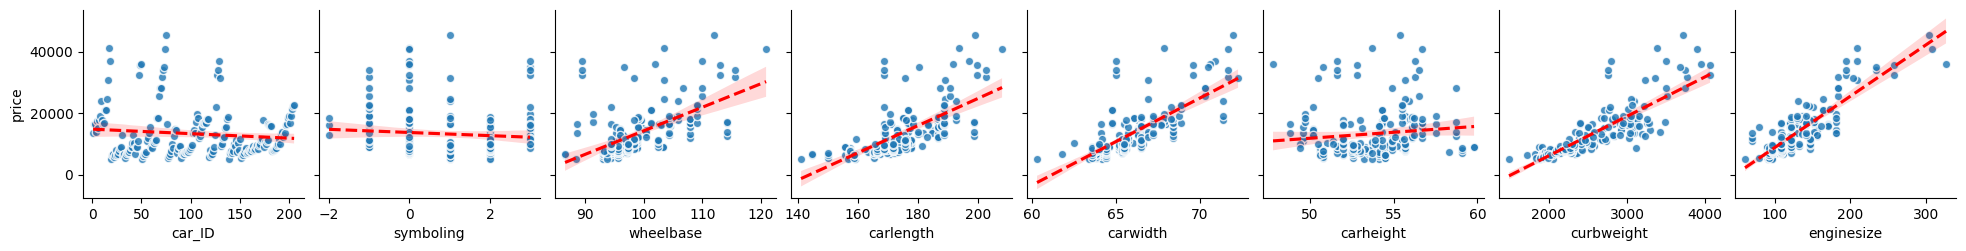

In [8]:
# Quick EDA for features related to target.
sns.pairplot(df, 
             y_vars = 'price',
             x_vars = num_cols[:8],
             kind = 'reg',
             plot_kws = plot_kws);

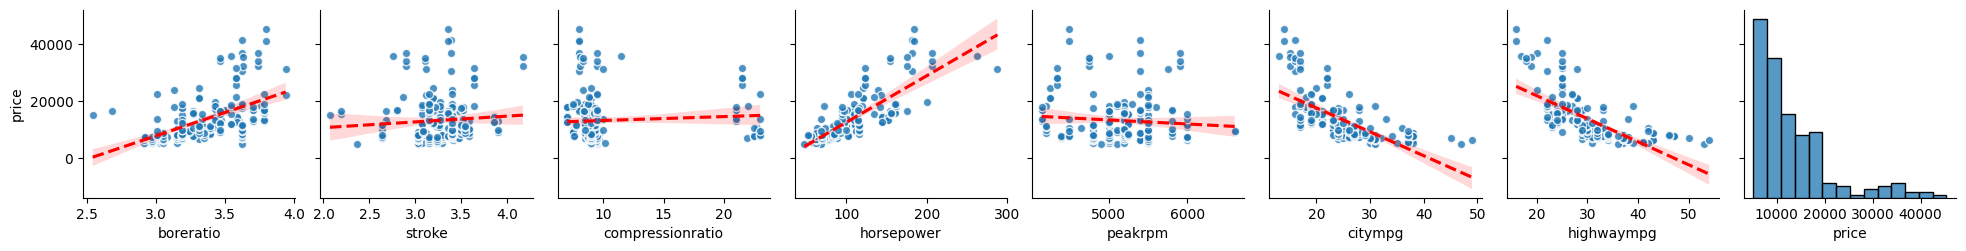

In [9]:
# Plot the rest of the pairplots
sns.pairplot(df, 
             y_vars = 'price',
             x_vars = num_cols[8:],
             kind = 'reg',
             plot_kws = plot_kws);

In [10]:
# Drop columns without a linear relationship to price
cols_to_drop = ['price',
                'car_ID',
                'symboling',
                'stroke',
                'compressionratio',
                'peakrpm']

In [11]:
# Call the info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

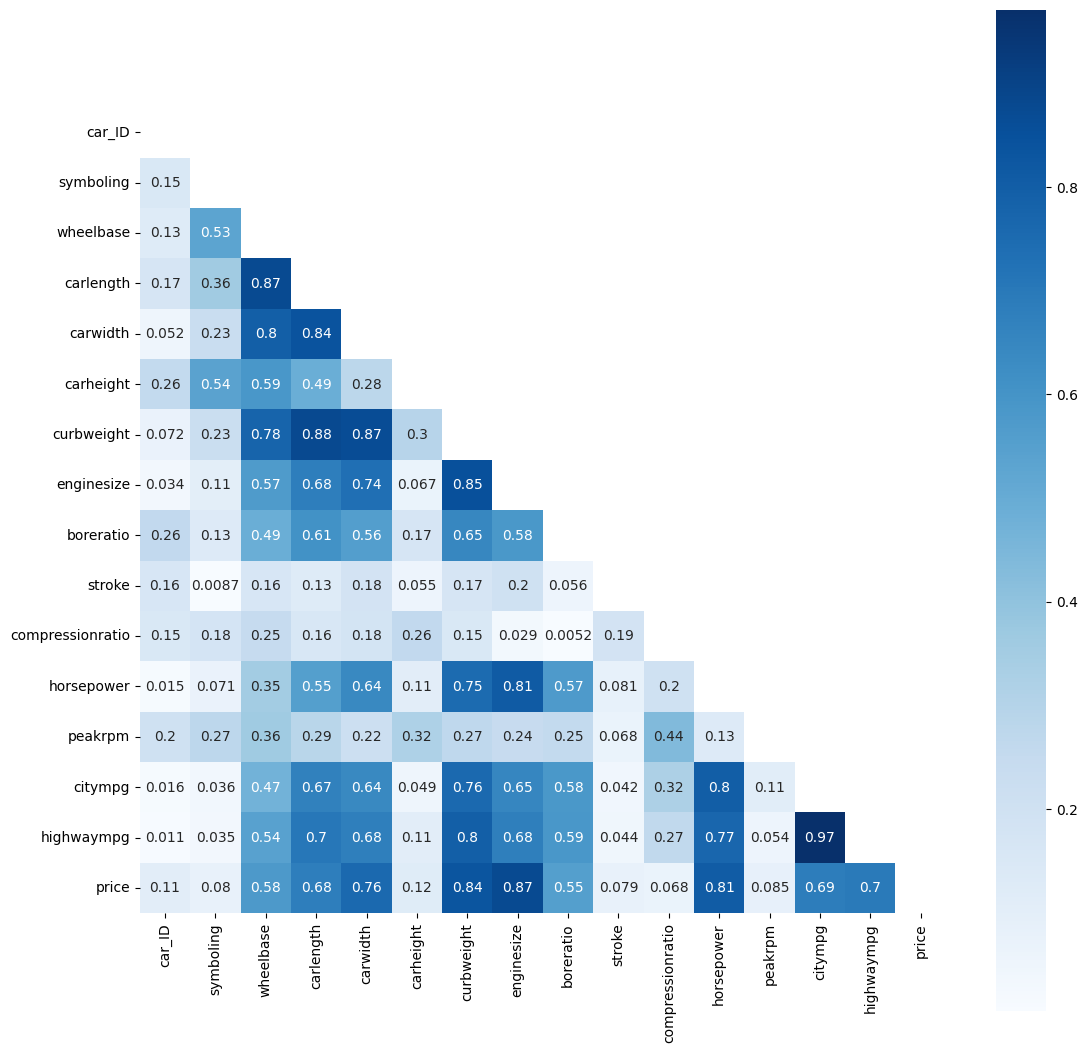

In [12]:
# Make a correlation matrix
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize = (13, 13));
sns.heatmap(corr, square = True, cmap = 'Blues', annot = True, mask = mask);

In [13]:
# Drop columns with multicolinearity
cols_to_drop.extend(['wheelbase',
                     'carlength',
                     'carwidth',
                     'curbweight',
                     'horsepower',
                     'citympg'])

In [14]:
# Set the target and features
X = df.drop(columns = cols_to_drop).copy()
y = df['price'].copy()

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
# Get the numeric and categorical columns
cat_select = make_column_selector(dtype_include = 'object')
num_select = make_column_selector(dtype_include = 'number')
cat_cols = cat_select(X_train)
num_cols = num_select(X_train)

In [17]:
# Make a preprocessing pipeline
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown = 'ignore',
                         sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))
preprocessor = make_column_transformer((cat_pipe, cat_cols), 
                                       (num_pipe, num_cols),
                                       remainder = 'passthrough')

In [18]:
# Fit the column transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['CarName', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['carheight', 'enginesize', 'boreratio',
                                  'highwaympg'])])

In [19]:
# Explore the transformation as a data frame
pd.DataFrame(preprocessor.transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,50.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,34.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,37.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,25.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,49.7,181.0,3.43,25.0
149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,55.7,164.0,3.31,25.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,54.5,97.0,3.15,37.0
151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,171.0,3.27,24.0


In [20]:
# Make an empty list for the feature names
final_features = []

In [21]:
# Investigate the categorical pipeline
preprocessor.named_transformers_['pipeline-1'].named_steps

{'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False)}

In [22]:
# Get the one hot encoder steps
ohe_step = preprocessor.named_transformers_['pipeline-1'].\
named_steps['onehotencoder']
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [23]:
# Get the feature names
cat_features = ohe_step.get_feature_names_out(cat_cols)
cat_features

array(['CarName_Nissan versa', 'CarName_alfa-romero Quadrifoglio',
       'CarName_alfa-romero giulia', 'CarName_alfa-romero stelvio',
       'CarName_audi 100 ls', 'CarName_audi 100ls', 'CarName_audi 4000',
       'CarName_audi 5000', 'CarName_audi fox', 'CarName_bmw 320i',
       'CarName_bmw x1', 'CarName_bmw x3', 'CarName_bmw z4',
       'CarName_buick opel isuzu deluxe',
       'CarName_buick regal sport coupe (turbo)', 'CarName_buick skyhawk',
       'CarName_buick skylark', 'CarName_chevrolet vega 2300',
       'CarName_dodge challenger se', 'CarName_dodge colt (sw)',
       'CarName_dodge coronet custom', 'CarName_dodge d200',
       'CarName_dodge dart custom', 'CarName_dodge rampage',
       'CarName_honda accord', 'CarName_honda accord cvcc',
       'CarName_honda accord lx', 'CarName_honda civic',
       'CarName_honda civic (auto)', 'CarName_honda civic 1500 gl',
       'CarName_honda civic cvcc', 'CarName_honda prelude',
       'CarName_isuzu D-Max ', 'CarName_isuzu MU-X'

In [24]:
# Add the categorical feature names to the final_features list
final_features.extend(cat_features)

In [25]:
# Add the numeric feature names to the final_features list
final_features.extend(num_cols)
final_features

['CarName_Nissan versa',
 'CarName_alfa-romero Quadrifoglio',
 'CarName_alfa-romero giulia',
 'CarName_alfa-romero stelvio',
 'CarName_audi 100 ls',
 'CarName_audi 100ls',
 'CarName_audi 4000',
 'CarName_audi 5000',
 'CarName_audi fox',
 'CarName_bmw 320i',
 'CarName_bmw x1',
 'CarName_bmw x3',
 'CarName_bmw z4',
 'CarName_buick opel isuzu deluxe',
 'CarName_buick regal sport coupe (turbo)',
 'CarName_buick skyhawk',
 'CarName_buick skylark',
 'CarName_chevrolet vega 2300',
 'CarName_dodge challenger se',
 'CarName_dodge colt (sw)',
 'CarName_dodge coronet custom',
 'CarName_dodge d200',
 'CarName_dodge dart custom',
 'CarName_dodge rampage',
 'CarName_honda accord',
 'CarName_honda accord cvcc',
 'CarName_honda accord lx',
 'CarName_honda civic',
 'CarName_honda civic (auto)',
 'CarName_honda civic 1500 gl',
 'CarName_honda civic cvcc',
 'CarName_honda prelude',
 'CarName_isuzu D-Max ',
 'CarName_isuzu MU-X',
 'CarName_jaguar xf',
 'CarName_jaguar xj',
 'CarName_jaguar xk',
 'CarName_

In [26]:
# Transform X_train and X_test into data frames
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns = final_features,
                          index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns = final_features,
                         index = X_test.index)
display(X_train_df.head(), X_test_df.head())

,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,highwaympg
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,50.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,34.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,37.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,25.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,30.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,highwaympg
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,55.7,209.0,3.62,22.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,52.0,131.0,3.13,22.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,54.7,120.0,3.33,34.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,56.1,121.0,3.54,28.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,58.7,183.0,3.58,25.0


In [27]:
# Add a constant column to X_train_df and X_test_df
X_train_df = sm.add_constant(X_train_df, has_constant = 'add', prepend = False)
X_test_df = sm.add_constant(X_test_df, has_constant = 'add', prepend = False)

display(X_train_df.head(), X_test_df.head())

,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,highwaympg,const
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,54.5,103.0,2.99,50.0,1.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,54.9,122.0,3.31,34.0,1.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.5,97.0,3.15,37.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,53.1,136.0,3.19,25.0,1.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,146.0,3.62,30.0,1.0


,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,CarName_audi 100 ls,CarName_audi 100ls,CarName_audi 4000,CarName_audi 5000,CarName_audi fox,CarName_bmw 320i,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,carheight,enginesize,boreratio,highwaympg,const
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,55.7,209.0,3.62,22.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,131.0,3.13,22.0,1.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,54.7,120.0,3.33,34.0,1.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,56.1,121.0,3.54,28.0,1.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,58.7,183.0,3.58,25.0,1.0


In [44]:
# Construct a linear regression model
model = sm.OLS(y_train, X_train_df, hasconst = True)
result = model.fit()

     CarName_Nissan versa  CarName_alfa-romero Quadrifoglio  \
90                    0.0                               0.0   
173                   0.0                               0.0   
93                    0.0                               0.0   
5                     0.0                               0.0   
167                   0.0                               0.0   
..                    ...                               ...   
106                   0.0                               0.0   
14                    0.0                               0.0   
92                    0.0                               0.0   
179                   0.0                               0.0   
102                   0.0                               0.0   

     CarName_alfa-romero giulia  CarName_alfa-romero stelvio  \
90                          0.0                          0.0   
173                         0.0                          0.0   
93                          0.0                    

In [29]:
# Evaluate the model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     13.43
Date:                Sat, 22 Oct 2022   Prob (F-statistic):           3.25e-07
Time:                        13:35:49   Log-Likelihood:                -1226.7
No. Observations:                 153   AIC:                             2727.
Df Residuals:                      16   BIC:                             3143.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
CarName_Nissan versa                    -2804.5085   2684.656     -1.045      0.312   -8495.724    2886.707
CarName_alfa-romero Quadrifoglio         6498.0670   3670.807      1.770      0.096   -1283.696    1.43e+04
CarName_alfa-romero giulia              -3371.4333   3731.813     -0.903      0.380   -1.13e+04    4539.657
CarName_alfa-romero stelvio              -366.4333   3731.813     -0.098      0.923   -8277.524    7544.657
CarName_audi 100 ls                      1595.8431   2547.794      0.626      0.540   -3805.239    6996.926
CarName_audi 100ls                      -2486.5053   2294.770     -1.084      0.295   -7351.201    2378.191
CarName_audi 4000                        3771.9598   2910.084      1.296      0.213   -2397.142    9941.062
CarName_audi 5000                       -1432.0739   2835.255     -0.505      0.620   -7442.547    4578.399
CarName_audi fox                        -5627.9208   3045.289     -1.848      0.083   -1.21e+04     827.803
CarName_bmw 320i                          1.16e+04   3733.500      3.108      0.007    3687.380    1.95e+04
CarName_bmw x1                           9169.0900   5090.716      1.801      0.091   -1622.746       2e+04
CarName_bmw x3                           1.195e+04   4591.155      2.603      0.019    2219.007    2.17e+04
CarName_bmw z4                           1.251e+04   5173.565      2.418      0.028    1540.872    2.35e+04
CarName_buick opel isuzu deluxe          2288.2200   3611.558      0.634      0.535   -5367.941    9944.381
CarName_buick regal sport coupe (turbo)  -137.6464   2986.887     -0.046      0.964   -6469.564    6194.271
CarName_buick skyhawk                    1.138e+04   4209.909      2.704      0.016    2457.883    2.03e+04
CarName_buick skylark                      16.4812   2027.138      0.008      0.994   -4280.859    4313.822
CarName_chevrolet vega 2300             -1465.2401   2862.237     -0.512      0.616   -7532.912    4602.432
CarName_dodge challenger se             -2129.2616   3223.911     -0.660      0.518   -8963.647    4705.124
CarName_dodge colt (sw)                 -1927.6121   3212.035     -0.600      0.557   -8736.821    4881.597
CarName_dodge coronet custom            -3321.0262   3848.788     -0.863      0.401   -1.15e+04    4838.041
CarName_dodge d200                      -3420.2244   3621.289     -0.944      0.359   -1.11e+04    4256.566
CarName_dodge dart custom               -3611.2365   4045.989     -0.893      0.385   -1.22e+04    4965.877
CarName_dodge rampage                   -2555.5416   3282.153     -0.779      0.448   -9513.396    4402.313
CarName_honda accord                    -3868.4983   4542.918     -0.852      0.407   -1.35e+04    5762.058
CarName_honda accord cvcc               -3027.2856   4574.1

In [30]:
# Evaluate the model on the test set
test_preds = result.predict(X_test_df)
print('Test r2:', r2_score(y_test, test_preds))
print('Test MSE:', mean_squared_error(y_test, test_preds))

Test r2: 0.5647534461807664
Test MSE: 29448580.2606559


# Diagnosing the Model

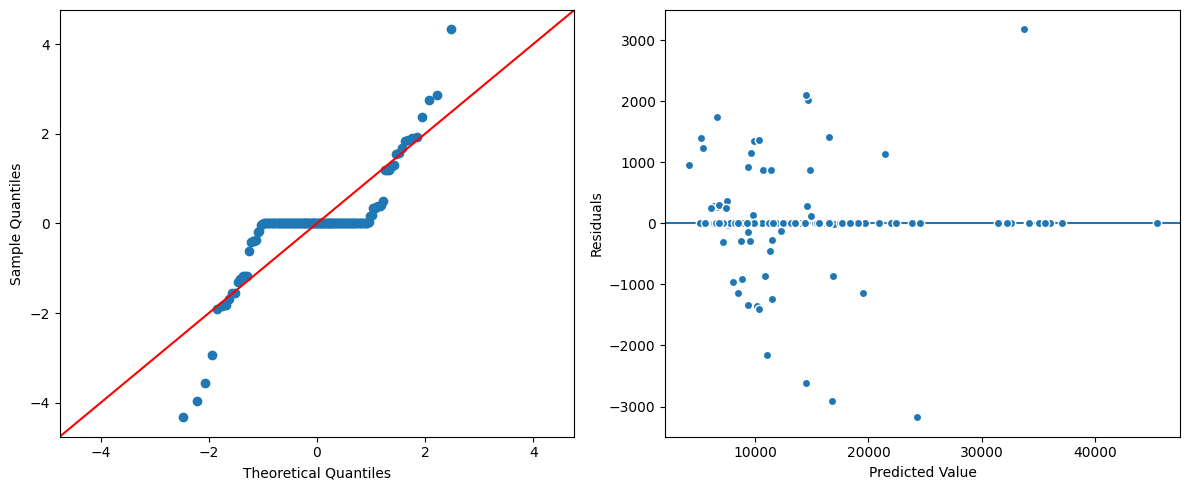

In [31]:
# Evaluate the model
evaluate_ols(result, X_train_df, y_train)

In [32]:
# Get the z-scores of the target
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))
z_price = pd.Series(z_price.flatten(), index = y_train.index)

In [33]:
# Find any outliers
idx_outliers = z_price > 3
idx_outliers.sum()

2

In [34]:
# Remove the outliers
X_train_cln = X_train_df[~idx_outliers]
y_train_cln = y_train[~idx_outliers]

In [35]:
# Determine the range our model is valid for
print('Min:', y_train_cln.min())
print('Max:', y_train_cln.max())

Min: 5118.0
Max: 36880.0


In [36]:
# Remove outliers from the test data
z_price_test = scaler.transform(y_test.values.reshape(-1, 1))
z_price_test = pd.Series(z_price_test.flatten(), index = y_test.index)
idx_outliers_test = z_price_test > 3
print(idx_outliers_test.sum())
X_test_cln = X_test_df[~idx_outliers_test]
y_test_cln = y_test[~idx_outliers_test]

2


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     11.31
Date:                Sat, 22 Oct 2022   Prob (F-statistic):           1.16e-06
Time:                        13:35:50   Log-Likelihood:                -1211.7
No. Observations:                 151   AIC:                             2693.
Df Residuals:                      16   BIC:                             3101.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

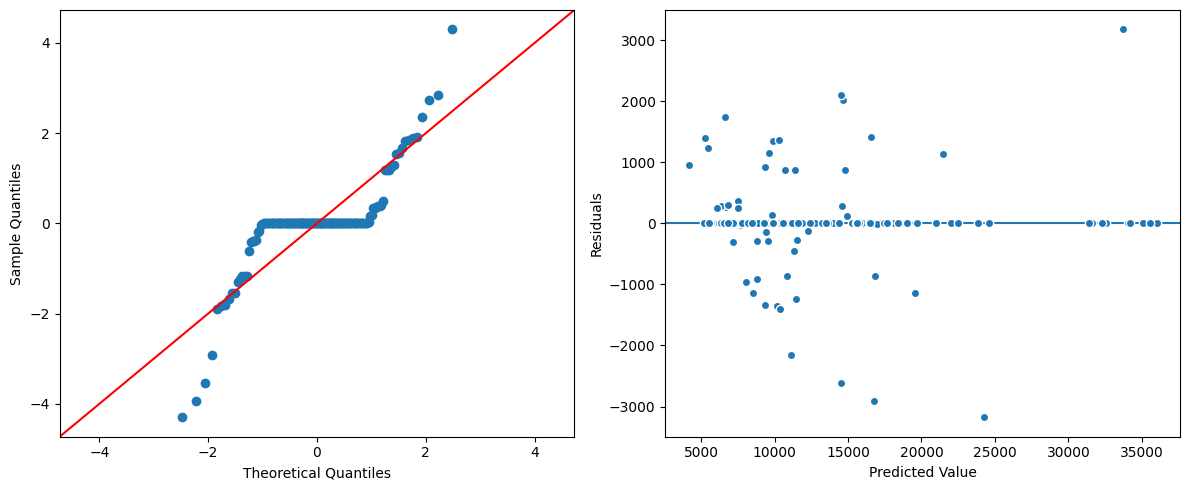

In [37]:
# Construct a model with the outliers removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

In [38]:
# Investigate the p-values
p_vals = result.pvalues
p_vals[p_vals > 0.05]

CarName_Nissan versa                0.311167
CarName_alfa-romero Quadrifoglio    0.094839
CarName_alfa-romero giulia          0.449114
CarName_alfa-romero stelvio         0.930924
CarName_audi 100 ls                 0.540147
                                      ...   
fuelsystem_spfi                     0.686068
carheight                           0.465738
boreratio                           0.307699
highwaympg                          0.506300
const                               0.388150
Length: 143, dtype: float64

In [39]:
# Determine the number of insignificant p-values
(p_vals > 0.05).sum()

143

In [40]:
# Determine how many carName columns have insignificant p-values
print(p_vals[p_vals > 0.05].index.str.startswith('CarName').sum())
print(p_vals.index.str.startswith('CarName').sum())

106
119


In [41]:
# Determine the features with insignificant p-values not starting with CarName
filter = p_vals.index.str.startswith('CarName')
p_vals[~filter]

fueltype_diesel          0.679876
fueltype_gas             0.270345
aspiration_std           0.438359
aspiration_turbo         0.362022
doornumber_four          0.358203
doornumber_two           0.433114
carbody_convertible      0.321593
carbody_hardtop          0.708935
carbody_hatchback        0.568778
carbody_sedan            0.488464
carbody_wagon            0.475797
drivewheel_4wd           0.358987
drivewheel_fwd           0.250596
drivewheel_rwd           0.715693
enginelocation_front     0.762448
enginelocation_rear      0.016736
enginetype_dohc          0.510302
enginetype_dohcv         0.917218
enginetype_l             0.401870
enginetype_ohc           0.555609
enginetype_ohcf          0.794183
enginetype_ohcv          0.268770
enginetype_rotor         0.011471
cylindernumber_eight     0.264055
cylindernumber_five      0.094931
cylindernumber_four      0.391813
cylindernumber_six       0.378250
cylindernumber_twelve    0.058287
cylindernumber_two       0.011471
fuelsystem_1bb

In [47]:
# enginesize is the only feature with a significant p-value.
X_train_cln = pd.DataFrame(X_train_cln['enginesize'])
X_train_cln = sm.add_constant(X_train_cln,
                              prepend = False,
                              has_constant = 'add')
X_train_cln

,enginesize,const
90,103.0,1.0
173,122.0,1.0
93,97.0,1.0
5,136.0,1.0
167,146.0,1.0
...,...,...
106,181.0,1.0
14,164.0,1.0
92,97.0,1.0
179,171.0,1.0


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     390.0
Date:                Sat, 22 Oct 2022   Prob (F-statistic):           1.91e-43
Time:                        14:30:01   Log-Likelihood:                -1458.9
No. Observations:                 151   AIC:                             2922.
Df Residuals:                     149   BIC:                             2928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
enginesize   160.4633      8.125     19.749      0.0

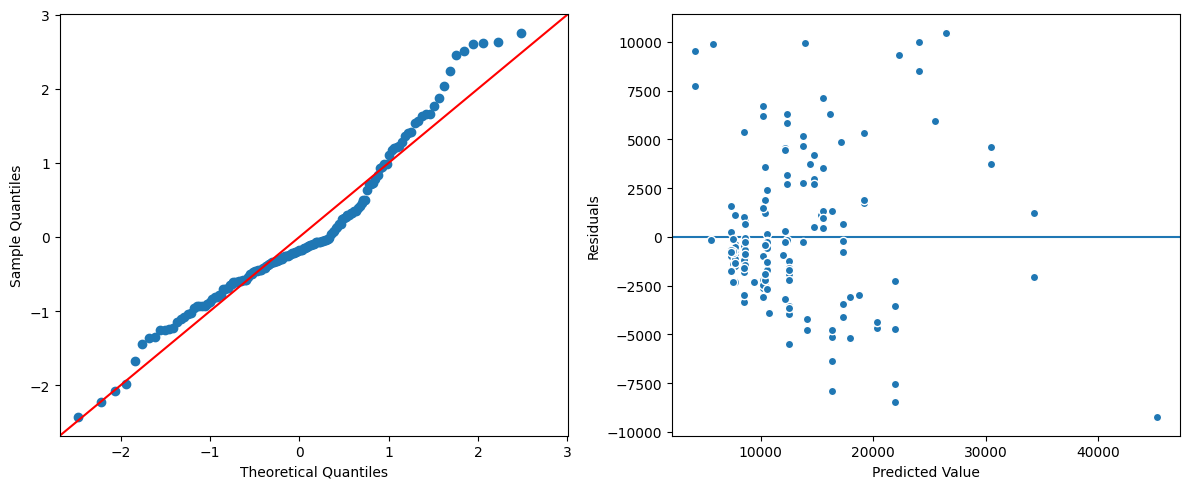

In [48]:
# Construct a model with the outliers removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)